In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import requests

In [2]:
## Cargar fuente Pricestats

pd.read_csv('./../data/info/Argentina_inflation_pricestats.csv')

cpi = pd.read_csv('./../data/info/Argentina_inflation_pricestats.csv').dropna(subset = ['index'])
cpi.index = pd.date_range("1943-01", periods=len(cpi), freq = 'M')

## Cargar fuente Indec para IPC post 2015
### Descargar info actualizada en ipc_b201612_mensual.csv
csv_url = 'https://infra.datos.gob.ar/catalog/sspm/dataset/145/distribution/145.3/download/indice-precios-al-consumidor-nivel-general-base-diciembre-2016-mensual.csv'
req = requests.get(csv_url)
csv_file = open('./../data/info/ipc_b201612_mensual.csv', 'wb')
csv_file.write(req.content)
csv_file.close()

## Usar archivo
cpi2 = pd.read_csv('./../data/info/ipc_b201612_mensual.csv',
                   usecols = ['ipc_ng_nacional']).astype(float)
cpi2.index = pd.date_range("2016-12", periods=len(cpi2), freq = 'M')
cpi2.columns = ['index']

### Graficar el empalme de indices

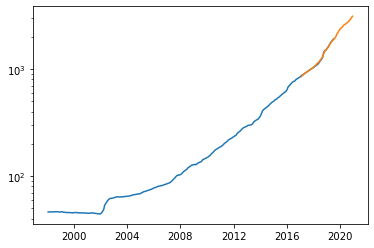

In [3]:
m = np.mean(cpi.loc['2017':]['index'].values/cpi2.loc['2017':]['index'].values[:len(cpi.loc['2017':])])

plt.plot(cpi.loc['1998':][['index']])
plt.plot(m*cpi2.loc['2017':][['index']])

plt.yscale('log')
plt.show()

In [4]:
## Si esta todo ok se pueden unir
cpi = pd.concat([cpi.loc[:cpi2.index.values[0]][['index']],
           m*cpi2.iloc[1:]], )

In [5]:
## Tasa de inflacion de los ultimos 12 meses. Se usa para completar la inflacion del ultimo mes antes que se mida.
r = cpi.pct_change().tail(12).mean()[0]

## Estirar la serie de CPI hasta el dia de hoy (para precios actualizados)
cpi = pd.concat([cpi, pd.DataFrame([], 
                                   index = pd.date_range(cpi.index[-1] + pd.DateOffset(months=1), 
                                                         pd.datetime.today() + pd.DateOffset(months=1), freq = 'M'))])

last_valid_ix = cpi.dropna().iloc[-1] # Level of the cpi index in last valid month

cpi['avg_rate'] = pd.Series((1 + r)**range(len(cpi)), index = cpi.index)  ## Compute the exponential curve

# Bring to actual level
ratio = cpi.loc[last_valid_ix.name].avg_rate / cpi.loc[last_valid_ix.name]['index'] 
cpi['avg_rate'] = cpi['avg_rate']/ratio  

# Complete cpi series up to present and remove exponential
cpi['index'] = cpi['index'].fillna(cpi['avg_rate'])
cpi = cpi.drop('avg_rate', axis = 1)

nivel_precios_actual = cpi.tail(1)['index']
display(nivel_precios_actual)

<ipython-input-5-dafcf37e6765>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.today() + pd.DateOffset(months=1), freq = 'M'))])


2021-01-31    3270.799721
Freq: M, Name: index, dtype: float64

In [6]:
cpi.to_csv('./../data/info/indice_precios_M.csv')
cpi.tail()

,index
2020-09-30,2903.602346
2020-10-31,3012.805954
2020-11-30,3108.001733
2020-12-31,3188.361836
2021-01-31,3270.799721


In [7]:
cpi_ = cpi.groupby(pd.Grouper(freq='Q')).mean().loc['2003':'2020-09-30'][['index']]#.to_csv(...)
cpi_.set_index('index')
cpi_.index.name = 'Q'

cpi_.tail()

,index
Q,
2019-09-30,2021.096769
2019-12-31,2286.125270
2020-03-31,2488.067717
2020-06-30,2644.322902
2020-09-30,2825.482851


In [8]:
cpi_.to_csv('./../data/info/indice_precios_Q.csv')

In [9]:
# cpi = cpi.groupby(pd.Grouper(freq='Q')).mean().loc[str(startyr):str(endyr)][['index']]#.to_csv(...)
# cpi.set_index('index')
# cpi.index.name = 'Q'
# #
# indice_precios = cpi